# Урок 9. Языковое моделирование

## Задание
Разобраться с моделькой генерации текста, собрать самим или взять датасет с вебинара и обучить генератор.

## Решение

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import warnings # Не показывать предупреждения.
warnings.filterwarnings('ignore')

In [ ]:
path_to_file = 'evgenyi_onegin.txt'

In [ ]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))

Length of text: 286984 characters


In [ ]:
print(text[:300])

Александр Сергеевич Пушкин

                                Евгений Онегин
                                Роман в стихах

                        Не мысля гордый свет забавить,
                        Вниманье дружбы возлюбя,
                        Хотел бы я тебе представить
                     


In [ ]:
# Отсортируем все символы в датасете и удалим повтряющиеся.
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

131 unique characters


In [ ]:
#  Сделаем перевод номеров симоволов в текст.
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [ ]:
text_as_int, text[:30], len(text_as_int), len(text)

(array([ 71, 110, 104, ..., 104, 121,   0]),
 'Александр Сергеевич Пушкин\n\n  ',
 286984,
 286984)

### train and target

In [ ]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

А
л
е
к
с


In [ ]:
char_dataset.take(5)

<_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [ ]:
# Выполним разбиение текста на последовательности длинной 100 символов.
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

# Выведем первые 5 батчей на экран.
for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                          '
'      Роман в стихах\n\n                        Не мысля гордый свет забавить,\n                        '
'Вниманье дружбы возлюбя,\n                        Хотел бы я тебе представить\n                        '
'Залог достойнее тебя,\n                        Достойнее души прекрасной,\n                        Свят'
'ой исполненной мечты,\n                        Поэзии живой и ясной,\n                        Высоких д'


In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1] # Предсказываем по одному символу.
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
dataset

# Разделим его на тренировочную и тестовую выборки.

<_MapDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.int64, name=None), TensorSpec(shape=(100,), dtype=tf.int64, name=None))>

Print the first example input and target values:

In [ ]:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'Александр Сергеевич Пушкин\n\n                                Евгений Онегин\n                         '
Target data: 'лександр Сергеевич Пушкин\n\n                                Евгений Онегин\n                          '


In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).

BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 128

# Number of RNN units
rnn_units = 1024

In [ ]:
class RNNgenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units): #, batch_size):
        super(RNNgenerator, self).__init__()

        self.emb = tf.keras.layers.Embedding(vocab_size, embedding_dim) #, batch_input_shape=[batch_size, None])

        self.gru1 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')

        self.gru2 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')
        self.gru3 = tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=False,
                            recurrent_initializer='glorot_uniform')

        # self.lin_norm = tf.keras.layers.LayerNormalization()

        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, x):
        emb_x = self.emb(x)
        x = self.gru1(emb_x)
        x = self.gru2(x)
        x = self.gru3(x)

        x = self.dense(x)
        return x

model = RNNgenerator(vocab_size,
                     embedding_dim,
                     rnn_units=rnn_units
                     ) #,
                    #  batch_size= BATCH_SIZE)

# model.build(tf.TensorShape([1, None]))

In [ ]:
# model.summary()

## Train the model

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [ ]:
model.compile(optimizer='adam', loss=loss, metrics='accuracy')

### Configure checkpoints

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './RNN_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=28,
                                save_weights_only=True)

### Execute the training

In [ ]:
EPOCHS = 280

In [ ]:
history = model.fit(dataset,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback]
                   )

Epoch 1/280
44/44 [==============================] - 22s 245ms/step - loss: 2.2132 - accuracy: 0.5441
Epoch 2/280
44/44 [==============================] - 10s 224ms/step - loss: 1.6393 - accuracy: 0.5810
Epoch 3/280
44/44 [==============================] - 10s 203ms/step - loss: 1.4694 - accuracy: 0.5994
Epoch 4/280
44/44 [==============================] - 10s 216ms/step - loss: 1.3574 - accuracy: 0.6167
Epoch 5/280
44/44 [==============================] - 10s 204ms/step - loss: 1.3173 - accuracy: 0.6285
Epoch 6/280
44/44 [==============================] - 10s 216ms/step - loss: 1.2537 - accuracy: 0.6401
Epoch 7/280
44/44 [==============================] - 10s 218ms/step - loss: 1.2091 - accuracy: 0.6512
Epoch 8/280
44/44 [==============================] - 10s 212ms/step - loss: 1.1765 - accuracy: 0.6605
Epoch 9/280
44/44 [==============================] - 10s 224ms/step - loss: 1.1249 - accuracy: 0.6729
Epoch 10/280
44/44 [==============================] - 10s 216ms/step - loss: 1.067

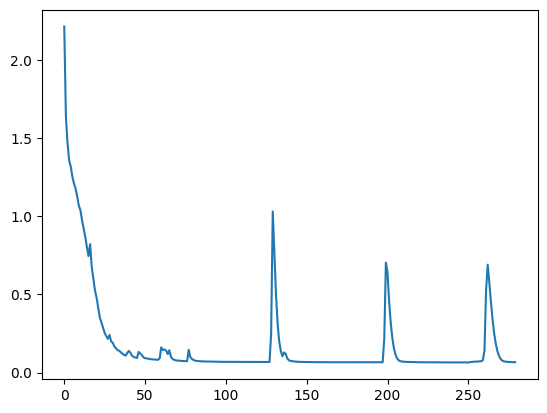

In [ ]:
plt.plot(history.history['loss'])
plt.show()

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'./RNN_checkpoints/ckpt_280'

# Востановим модель из кеша.

In [ ]:
model = RNNgenerator(vocab_size, embedding_dim, rnn_units)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

## Генерация текста.

In [ ]:
# Number of characters to generate
num_generate = 500

# Low temperature results in more predictable text.
# Higher temperature results in more surprising text.
# Experiment to find the best setting.
temperature = 1

In [ ]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
text_ = generate_text(model, start_string=u"И вот идет уже ")
print(text_)

И вот идет уже вим Ненануташи    каны     бы,
        Таму,
     Так    борискатларысаточь     Додя     чалиту  найни         х         н?
   о)
    мушей          ез вз нанысими,
           Ме
       пи  нелалихочнаснилесь       Нобумравени    Пой,
               зи               В   Таю
           ном    Момныл плужный           ск,
                             Изони   Алей         А,               буши                 каланый,
     тал,
            Еща     ны,
 Ещед,
         ду кох
   ужнней     Не Тазныли


### На 200-ой эпохе вродебы к-во было не плохим. Посмотрим как пройдет генерация текста.

In [ ]:
model = RNNgenerator(vocab_size, embedding_dim, rnn_units)
model.load_weights('./RNN_checkpoints/ckpt_200')
model.build(tf.TensorShape([1, None]))

In [ ]:
text_ = generate_text(model, start_string=u"И вот идет уже ")
print(text_)

И вот идет уже в.     У      Я               Тате  коглетый,
     ный,
           н,            боивогле    м Нево     и       .
                          коешный           кари,
    ГНетя.   ны,
   XVI
       даж      XXVаяриж  чт      Го                        ж        Серя          бланет  л           бы     с            Тараритономавей      ко,
         коской....
 му ско    вый,  ветаный,
       к ле      ты         сенеть                  бо вы,
                  Блый              рх,     прный       си,


# Дальше можно не смотреть.

> Хотел проверить, как поведет себя модель с установленным параметром "return_state=True".(подсмотрел в методичке по [tensorflow]( https://www.tensorflow.org/text/tutorials/text_generation)). Т.к. модель обучается очень долго, я просто загрузил веса из модели №1. Благо модели отличаются только указанным параметром. Но, результат получился не очень!

# Попробуем обучить модель с сохранением состояния.

In [ ]:
class RNNgenerator_1(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru2 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.gru3 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, x, states=None, return_state=False):

    x = self.embedding(x)

    if states is None:
      states = self.gru1.get_initial_state(x)

    x, states = self.gru1(x, initial_state=states)
    x, states = self.gru2(x, initial_state=states)
    x, states = self.gru3(x, initial_state=states)

    x = self.dense(x)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
checkpoint_dir = './RNN_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=1,
                                save_weights_only=True)

In [ ]:
model_1 = RNNgenerator_1(
                 vocab_size= vocab_size,
                 embedding_dim=embedding_dim,
                 rnn_units=rnn_units,
                )

In [ ]:
model_1.compile(optimizer='adam', loss=loss, metrics='accuracy')

In [ ]:
# Загрузим веса из чекпоинтов.

# model_1.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_1.load_weights('./RNN_checkpoints/ckpt_200')

## Генерация текста.

In [ ]:
def generate_text_1(model, start_string, states, temperature):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions, states = model(input_eval, states=states, return_state=True)
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
num_generate = 500
temperature = 0.6
states = None
next_char = u"И вот идет уже "
text_generated=[]

In [ ]:
text = generate_text_1(model_1, next_char, states, temperature)
print(text)

# Model 2

In [ ]:
class RNNgenerator_2(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru2 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.gru3 = tf.keras.layers.GRU(rnn_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, x, states_1=None, states_2=None, states_3=None, return_state=False):

    x = self.embedding(x)

    if states is None:
      states_1 = self.gru1.get_initial_state(x)
      states_2 = self.gru1.get_initial_state(x)
      states_3 = self.gru1.get_initial_state(x)

    x, states_1 = self.gru1(x, initial_state=states_1)
    x, states_2 = self.gru2(x, initial_state=states_2)
    x, states_3 = self.gru3(x, initial_state=states_3)

    x = self.dense(x)

    if return_state:
      return x, states_1, states_2, states_3
    else:
      return x

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './RNN_2_checkpoints'
checkpoint_dir = './RNN_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=1,
                                save_weights_only=True)

In [ ]:
model_2 = RNNgenerator_2(
                 vocab_size= vocab_size,
                 embedding_dim=embedding_dim,
                 rnn_units=rnn_units,
                )

In [ ]:
model_2.compile(optimizer='adam', loss=loss, metrics='accuracy')

In [ ]:
# model_2.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_2.load_weights('./RNN_checkpoints/ckpt_200')

In [ ]:
def generate_text_2(model, start_string, states_1, states_2, states_3, temperature):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions, states_1,states_2, states_3 = model(input_eval, states_1=states_1, states_2=states_2, states_3=states_3, return_state=True)
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
num_generate = 500
temperature = .5
states_1 = None
states_2 = None
states_3 = None
next_char = u"И вот идет уже "
text_generated=[]

In [ ]:
text = generate_text_2(model_2, next_char, states_1, states_2, states_3, temperature)
print(text)